<a href="https://colab.research.google.com/github/Josh1313/PRUEBA_VISUALCODE/blob/master/1_STEP_MONDAYTransf_learning_catsanddogs_basic_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connectar a Drive

# En este archivo entrenaremos todo el notebook con el objetivo de los perros y gatos despues usaremos parte del mismo proceso para empezar un nuevo objetivo ya que usaremos el modelo del entrenamiento con nuevo objetivo y congelaremos quitaremos el preprocesamiento ya que solo usaremos el modelo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias

In [ ]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

# Variables de entorno

<font color="#FF0000">Aquí definireis vuestra ruta del proyecto de perros y Gatos</font>

In [ ]:
ANCHO_IMAGEN = 150
ALTURA_IMAGEN=150
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3

ruta_archivos = '/content/drive/MyDrive/DPL456/'

# Cargaremos datos en NPZ


In [ ]:
dict_npz = np.load(ruta_archivos+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

In [ ]:
x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [ ]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

# Montamos la Red Neuronal

## Cargar la parte de extraccion de features de VGG16

In [ ]:
# Creemos una red que será extracción de features basada en VGG16 entrenada con ImageNet

El parámetro include_top=False indica que no se debe incluir la capa superior del modelo VGG16. La capa superior se refiere a la capa de clasificación final que generalmente se utiliza para problemas de clasificación de imágenes. Al establecer este parámetro en False, estás omitiendo esa capa y conservando solo las capas convolucionales y de agrupación.

In [ ]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))# SON LOS PIXELES DE LAS IMAGENES
#  INLUDE TOP FALSE ES PARA SOLO AGARRAR LA PARTE QUE NECESITAMOS SOLO las convulaciones ni el faltten esta incorporado
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Desde aca le extraemos la ultima capa del modelo y se la asiganmos a una variable despues a esa variable le asignamos la funcion flatten para que aplane la salida que es el output del modelo

In [ ]:
output = model_vgg16.layers[-1].output  # en este extraemos la ultima capa y la asignamos a esa variable
output

<KerasTensor: shape=(None, 4, 4, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
output_layer = ks.layers.Flatten()(output)# en esta en la ultima capa le asignamos el flatten osea en la variable
output_layer

<KerasTensor: shape=(None, 8192) dtype=float32 (created by layer 'flatten')>

In [ ]:
model_prevgg16 = Model(model_vgg16.input, output_layer)
model_prevgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
# Veamos como va lo de "congelar" capas de entrenamiento, en este notebook no se realizara la congelacion todavia

## Pre-procesaremos las imagenes originales, pasandolas por VGG16, para poder usarlas en la parte de clasificacion/ en el segundo paso se borrara este preprocesamiento

In [ ]:
# Llevamos las imagenes desde su origen al cuello de botella de VGG16, justo después del Flatten() ACA SE BORRAR

In [ ]:
def llevar_a_cuello_botella (datos,model):
  return model.predict(datos)

In [ ]:
x_train_postvgg16 = llevar_a_cuello_botella(x_train_scaled, model_prevgg16)
x_val_postvgg16 = llevar_a_cuello_botella(x_val_scaled, model_prevgg16)
x_test_postvgg16 = llevar_a_cuello_botella(x_test_scaled, model_prevgg16)

32/32 [==============================] - 2s 63ms/step


# Montemos la red de clasificación

In [ ]:
# Definamos el output de salida de la transformacion VGG16
output_from_vgg16 = 8192 # en el segundo paso se le borrara esta linea y se actualizara el modelo

In [ ]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(ks.layers.InputLayer(input_shape=(output_from_vgg16)))
model_post_vgg.add(ks.layers.Dense(512, activation='relu', input_shape=(output_from_vgg16,)))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_post_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


# Creamos un optimizador

In [ ]:
# lee creamos un nuevp adam para que el modelo sea mas pequeno con un modelo de satos mas pequeno

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
new_adam = Adam(learning_rate=0.0005)


In [ ]:
model_post_vgg.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Early stopping!!

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)

# Encoding de etiquetas

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [ ]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

['cat' 'cat' 'cat' ... 'dog' 'dog' 'dog']
[0 0 0 ... 1 1 1]


array([0, 0, 0, ..., 1, 1, 1])

# Entrenar

In [ ]:
history = model_post_vgg.fit(x=x_train_postvgg16, y=y_train_encoded, batch_size=512,
                             epochs=100, callbacks=[callback],
                             validation_data=(x_val_postvgg16, y_val_encoded))

Epoch 1/100
10/10 [==============================] - 3s 44ms/step - loss: 1.2787 - accuracy: 0.5596 - val_loss: 0.6576 - val_accuracy: 0.5710
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 0.4755 - accuracy: 0.7736 - val_loss: 0.3083 - val_accuracy: 0.8740
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 0.3221 - accuracy: 0.8592 - val_loss: 0.2548 - val_accuracy: 0.8930
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 0.2584 - accuracy: 0.8918 - val_loss: 0.2402 - val_accuracy: 0.8970
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.2192 - accuracy: 0.9102 - val_loss: 0.2262 - val_accuracy: 0.9070
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - loss: 0.1825 - accuracy: 0.9242 - val_loss: 0.2175 - val_accuracy: 0.9070
Epoch 7/100
10/10 [==============================] - 0s 21ms/step - loss: 0.1649 - accuracy: 0.9370 - val_loss: 0.2204 - val_accuracy: 0.9070
Epoch 

# Guardamos el modelo

Aquí tenemos que guardar el modelo simple, pero tambien hemos de guardar, o bien el modelo de preproceso o bien los datos de test procesados en NPZ...

In [ ]:
# Modelo post VGG16
model_post_vgg.save(ruta_archivos+'model_with_basic_transfer_learning_post_vgg16.h5')

# Datos procesados de test/ en el segundo paso se borrara esta linea de codigo
np.savez_compressed(ruta_archivos+'post_vgg16_test_data.npz', x=x_test_postvgg16, y=y_test_encoded)


# Miremos que tal rinde el modelo en errores y accuracy

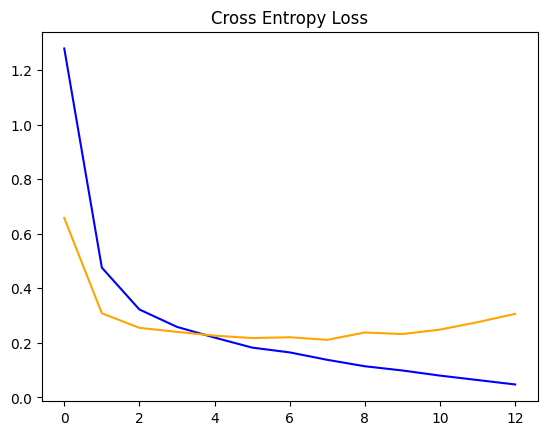

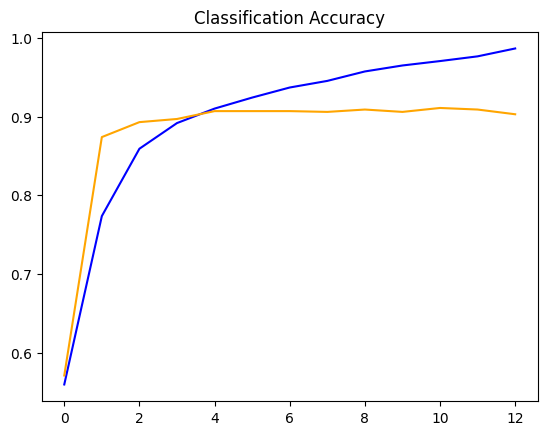

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [ ]:
_, acc = model_post_vgg.evaluate(x_test_postvgg16, y_test_encoded, verbose=0)
print('Modelo con Basic Transfer Learning > %.3f' % (acc * 100.0))


Modelo con Basic Transfer Learning > 90.500
